In [1]:
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(scran))
suppressPackageStartupMessages(library(scater))
suppressPackageStartupMessages(library(emmeans))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(lmerTest))
suppressPackageStartupMessages(library(msigdbr))
suppressPackageStartupMessages(library(dplyr))

In [2]:
setwd('/lustre/scratch117/cellgen/team297/kt16/COVID_imperial_renal/')
sce <- readRDS('h5ad/df.fil3_gex_bcells_vdj_sce_B_mem_all.RDS')
counts(sce) <- assays(sce)[['X']] # because i'm saving from a h5ad object with anndata2ri
sce$case_control <- factor(sce$case_control, levels = c('NEGATIVE', 'POSITIVE', 'RECOVERY'))
sce$WHO_temp_severity <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'))
sce$WHO_temp_severity_group <- factor(sce$WHO_temp_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical'))
sce$WHO_severity_group <- factor(sce$WHO_severity, levels = c('NA', 'mild', 'moderate', 'severe', 'critical'), labels = c('NA', 'mild_moderate', 'mild_moderate', 'severe_critical', 'severe_critical')) # interpreted as peak severity
sce$grouped_temp_severity <- ifelse(sce$WHO_temp_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")
sce$grouped_severity <- ifelse(sce$WHO_severity %in% c("mild", "moderate"), "mild_moderate", "severe_critical")
sce$age_scaled <- scale(sce$calc_age) # scale age
min_cells = 10
# remove samples >21 days
sce2 <- sce[,sce$time_from_infection <= 21] # prevent issues with spline
# Remove samples with less than 10 cells
nCells <- table(sce2$sample_id)
rmSamples <- names(nCells[nCells < min_cells])
sce2 <- sce2[, !sce2$sample_id %in% rmSamples]
# remove negatives and recoveries
sce3 <- sce2[,sce2$case_control == 'POSITIVE']
sce3

class: SingleCellExperiment 
dim: 32913 9279 
metadata(10): WHO_temp_severity_colors case_control_colors ...
  initial_cluster_B_colors seurat_clusters_colors
assays(2): X counts
rownames(32913): MIR1302-2HG FAM138A ... AC213203.1 FAM231C
rowData names(6): vst.mean vst.variance ... vst.variable GEX
colnames(9279): UK-CIC10689738+UK-CIC10690026_AAGGTTCGTGCGCTTG-1
  UK-CIC10689738+UK-CIC10690026_ACCTTTATCATGCAAC-1 ...
  UK-CIC10690384+UK-CIC10690576_TTTACTGAGGTGGGTT-1
  UK-CIC10690384+UK-CIC10690576_TTTATGCTCCTCAATT-1
colData names(72): orig.ident nCount_RNA ... grouped_severity
  age_scaled
reducedDimNames(5): X_harmony_rna X_pca_rna UMAP X_umapafterharmony_rna
  X_umapbeforeharmony_rna
altExpNames(0):

In [3]:
# Summarize Counts
smrzd <- aggregateAcrossCells(sce3, id = as.character(colData(sce3)[, c("sample_id")]))
smrzd <- logNormCounts(smrzd)
smrzd

class: SingleCellExperiment 
dim: 32913 123 
metadata(10): WHO_temp_severity_colors case_control_colors ...
  initial_cluster_B_colors seurat_clusters_colors
assays(2): counts logcounts
rownames(32913): MIR1302-2HG FAM138A ... AC213203.1 FAM231C
rowData names(6): vst.mean vst.variance ... vst.variable GEX
colnames(123): C101_110121 C101_130121 ... C93_2104 C93_2704
colData names(75): orig.ident nCount_RNA ... ncells sizeFactor
reducedDimNames(5): X_harmony_rna X_pca_rna UMAP X_umapafterharmony_rna
  X_umapbeforeharmony_rna
altExpNames(0):

In [4]:
unique(smrzd$centre)

[1] Cambridge NCL      
Levels: Cambridge NCL

In [5]:
## subset to waves
wave1 <- smrzd[,smrzd$centre == 'NCL']
wave2 <- smrzd[,smrzd$centre == 'Cambridge']

In [6]:
length(table(droplevels(wave1$individual_id)))

[1] 20

In [7]:
length(table(droplevels(wave2$individual_id)))

[1] 16

In [8]:
fullFormula = as.formula("geneset ~ splines::bs(time_from_infection, degree = 2) * grouped_severity + sex + ethnicity + age_scaled + (1|individual_id)")
fullFormula

geneset ~ splines::bs(time_from_infection, degree = 2) * grouped_severity + 
    sex + ethnicity + age_scaled + (1 | individual_id)

### Run the spline model but on gene sets

### Hallmark

In [9]:
m <- msigdbr(category = 'H')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)

In [10]:
seu1 <- as.Seurat(wave1)
data1 <- seu1@meta.data
seu1 <- AddModuleScore(seu1, features = genelists, name = names(genelists))

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_harmony_rna_ to Xharmonyrna_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xharmonyrna_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_pca_rna_ to Xpcarna_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xpcarna_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_umapafterharmony_rna_ to Xumapafterharmonyrna_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xumapafterharmonyrna_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_umapbeforeharmony_rna_ to Xumapbefor

In [11]:
seu2 <- as.Seurat(wave2)
data2 <- seu2@meta.data
seu2 <- AddModuleScore(seu2, features = genelists, name = names(genelists))

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_harmony_rna_ to Xharmonyrna_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xharmonyrna_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_pca_rna_ to Xpcarna_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xpcarna_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_umapafterharmony_rna_ to Xumapafterharmonyrna_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xumapafterharmonyrna_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_umapbeforeharmony_rna_ to Xumapbefor

In [12]:
fits1 <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data1$geneset <- seu1@meta.data[,x]
    fit <- lmerTest::lmer(fullFormula, data = data1)
    return(list(fit=fit, data=data1))
})

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



In [13]:
fits2 <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data2$geneset <- seu2@meta.data[,x]
    fit <- lmerTest::lmer(fullFormula, data = data2)
    return(list(fit=fit, data=data2))
})

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular



In [16]:
fit_res1 <- lapply(fits1, function(x) anova(x$fit))
singular1 <- lapply(fits1, function(x) as.numeric(isSingular(x$fit)))
conv1 <- lapply(fits1, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals1 <- lapply(fit_res1, function(x) x[6,6])
qvals1 <- p.adjust(pvals1, method = 'BH')
df1 = data.frame(pvals = unlist(pvals1), 
                qvals = unlist(qvals1), 
                singular = unlist(singular1), 
                conv = unlist(conv1), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df1 = df1[df1$qval < 0.05 & df1$singular == 0 & df1$conv == 0,]
df1

pvals,qvals,singular,conv
<dbl>,<dbl>,<dbl>,<int>


In [17]:
fit_res2 <- lapply(fits2, function(x) anova(x$fit))
singular2 <- lapply(fits2, function(x) as.numeric(isSingular(x$fit)))
conv2 <- lapply(fits2, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals2 <- lapply(fit_res2, function(x) x[6,6])
qvals2 <- p.adjust(pvals2, method = 'BH')
df2 = data.frame(pvals = unlist(pvals2), 
                qvals = unlist(qvals2), 
                singular = unlist(singular2), 
                conv = unlist(conv2), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df2 = df2[df2$qval < 0.05 & df2$singular == 0 & df2$conv == 0,]
df2

,pvals,qvals,singular,conv
,<dbl>,<dbl>,<dbl>,<int>
HALLMARK_INTERFERON_ALPHA_RESPONSE26,8.687254e-04,0.021718135,0,0
HALLMARK_INTERFERON_GAMMA_RESPONSE27,8.517634e-05,0.004258817,0,0


Warning message in splines::bs(time_from_infection, degree = 2L, knots = numeric(0), :
“some 'x' values beyond boundary knots may cause ill-conditioned bases”
Warning message in grid.Call.graphics(C_polygon, x$x, x$y, index):
“semi-transparency is not supported on this device: reported only once per page”
Warning message in grid.Call.graphics(C_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”


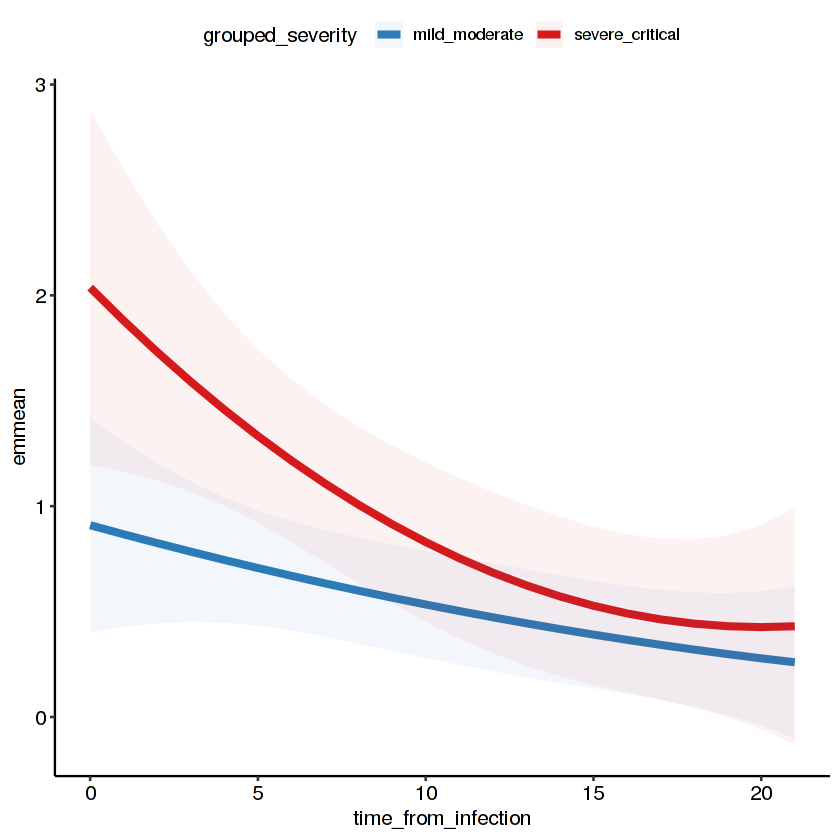

Warning message in grid.Call.graphics(C_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”


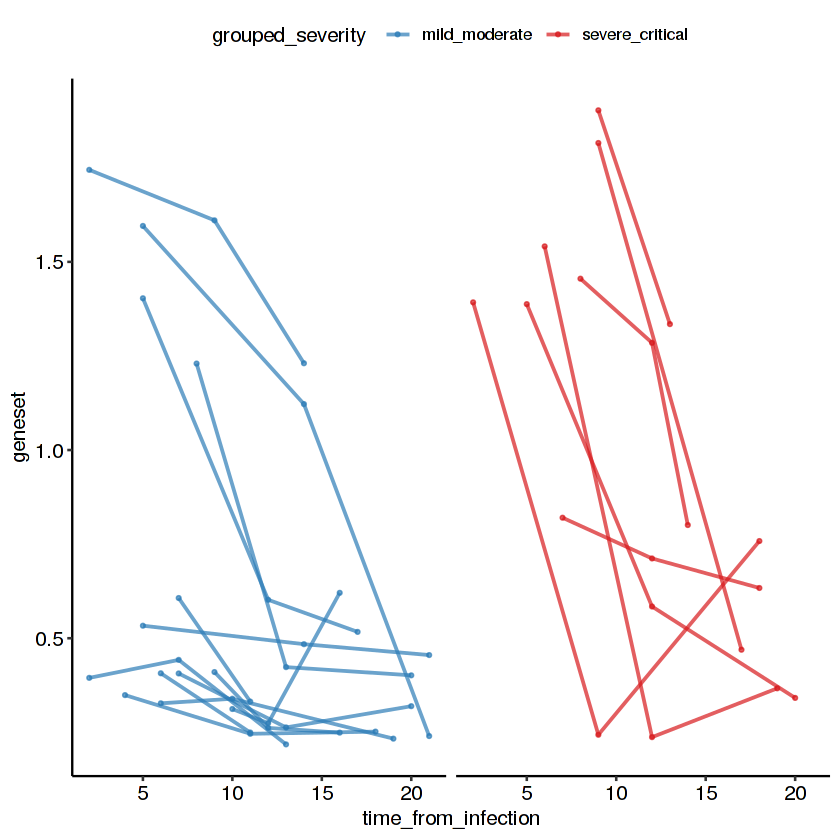

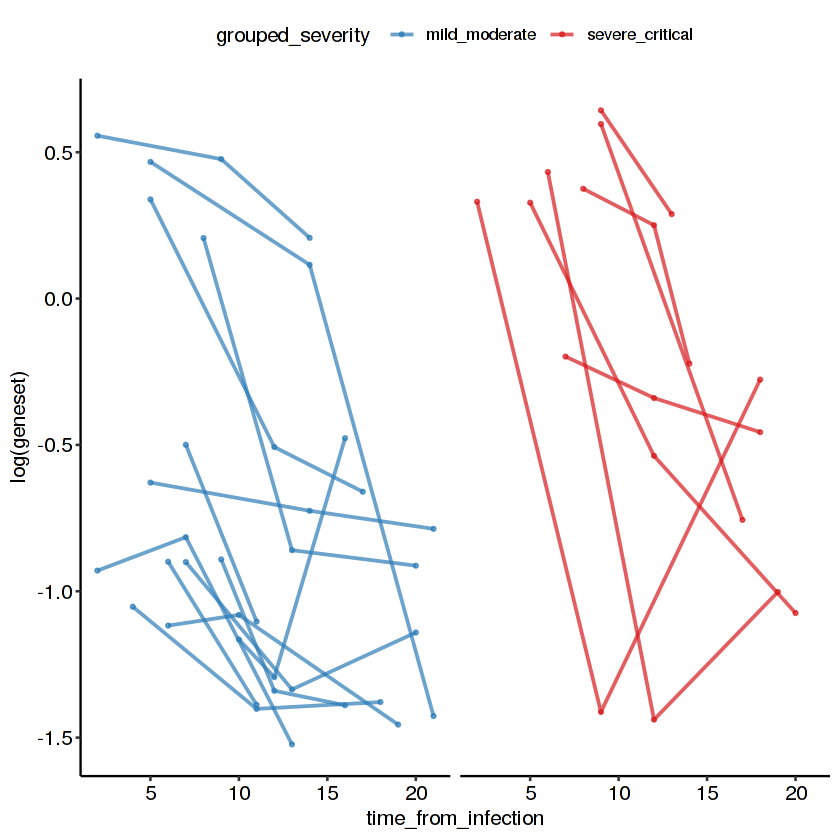

In [18]:
i = 26
x = emmeans(fits1[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

ggplot(fits1[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits1[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

Warning message in splines::bs(time_from_infection, degree = 2L, knots = numeric(0), :
“some 'x' values beyond boundary knots may cause ill-conditioned bases”
Warning message in grid.Call.graphics(C_polygon, x$x, x$y, index):
“semi-transparency is not supported on this device: reported only once per page”
Warning message in grid.Call.graphics(C_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”


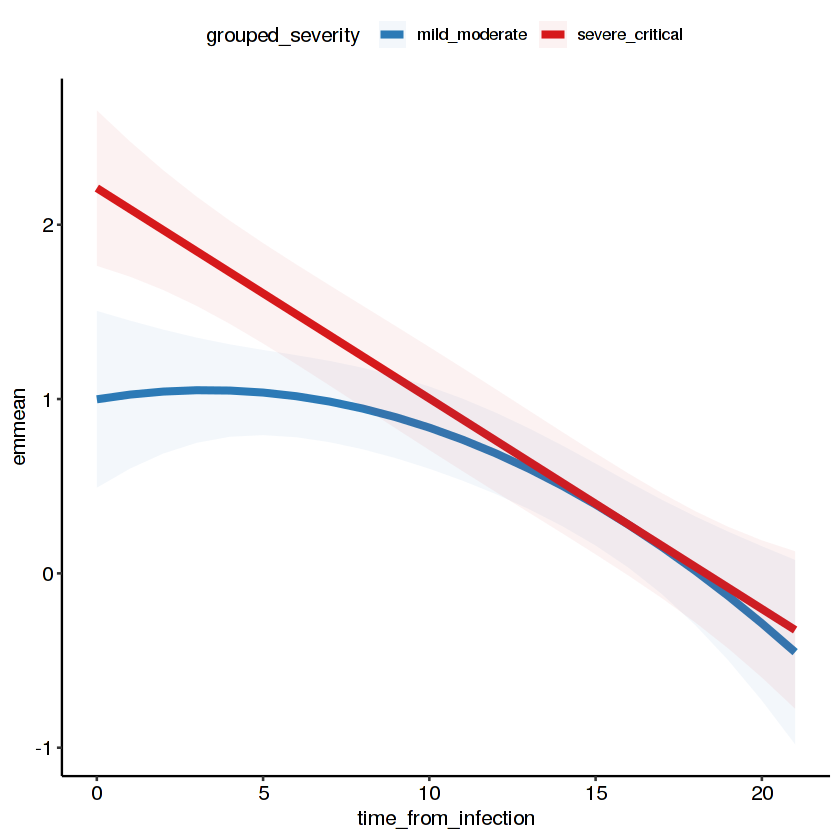

Warning message in log(geneset):
“NaNs produced”
Warning message in log(geneset):
“NaNs produced”
Warning message in log(geneset):
“NaNs produced”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message in grid.Call.graphics(C_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”


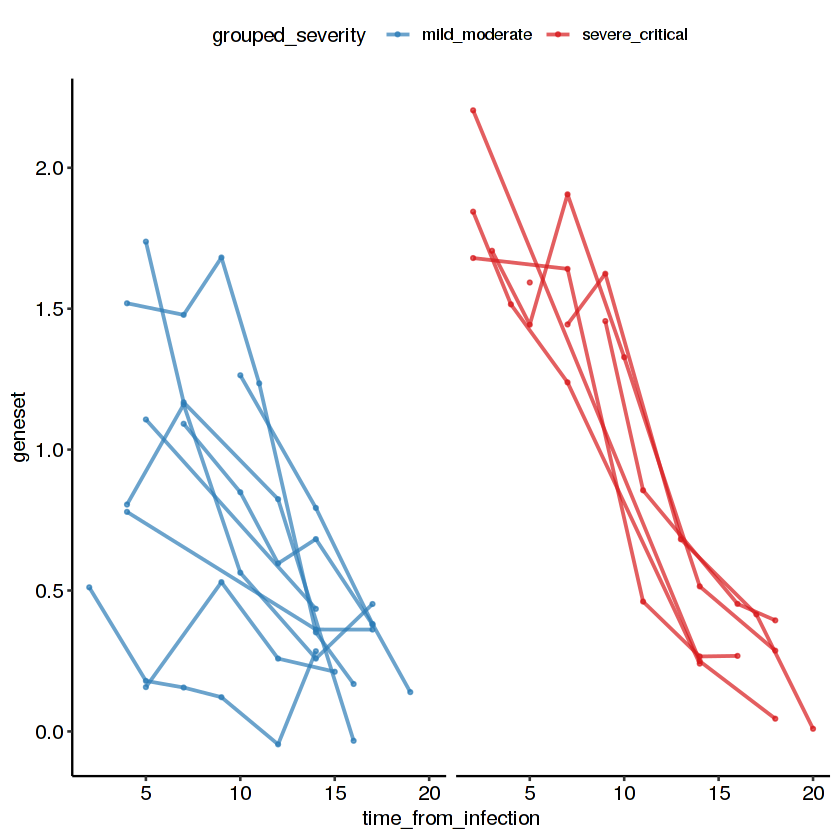

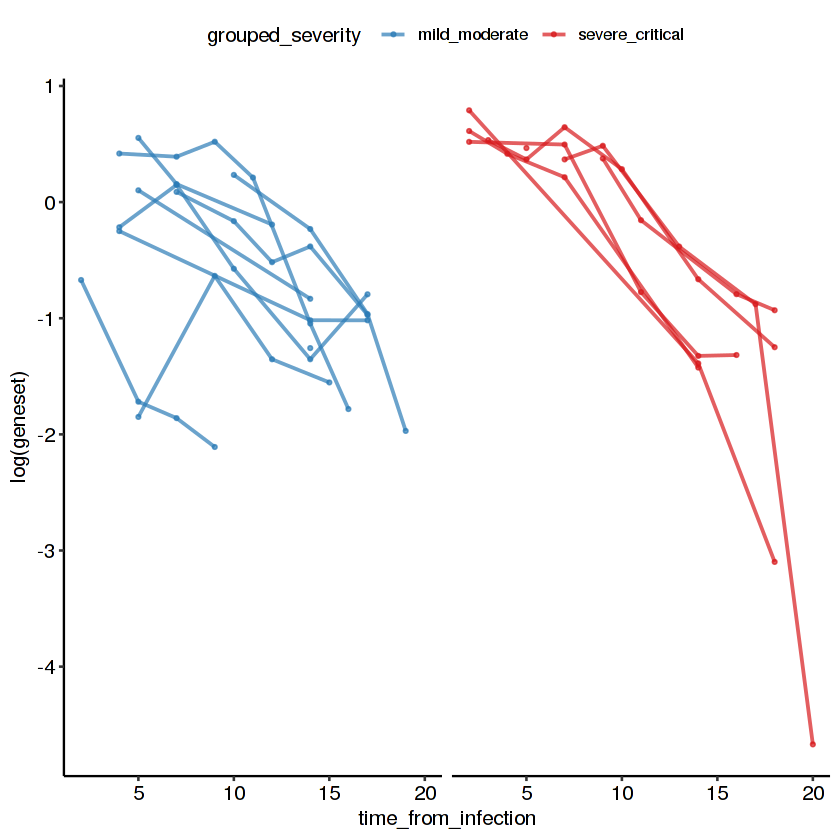

In [19]:
i = 26
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

ggplot(fits2[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

Warning message in splines::bs(time_from_infection, degree = 2L, knots = numeric(0), :
“some 'x' values beyond boundary knots may cause ill-conditioned bases”
Warning message in grid.Call.graphics(C_polygon, x$x, x$y, index):
“semi-transparency is not supported on this device: reported only once per page”
Warning message in grid.Call.graphics(C_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”


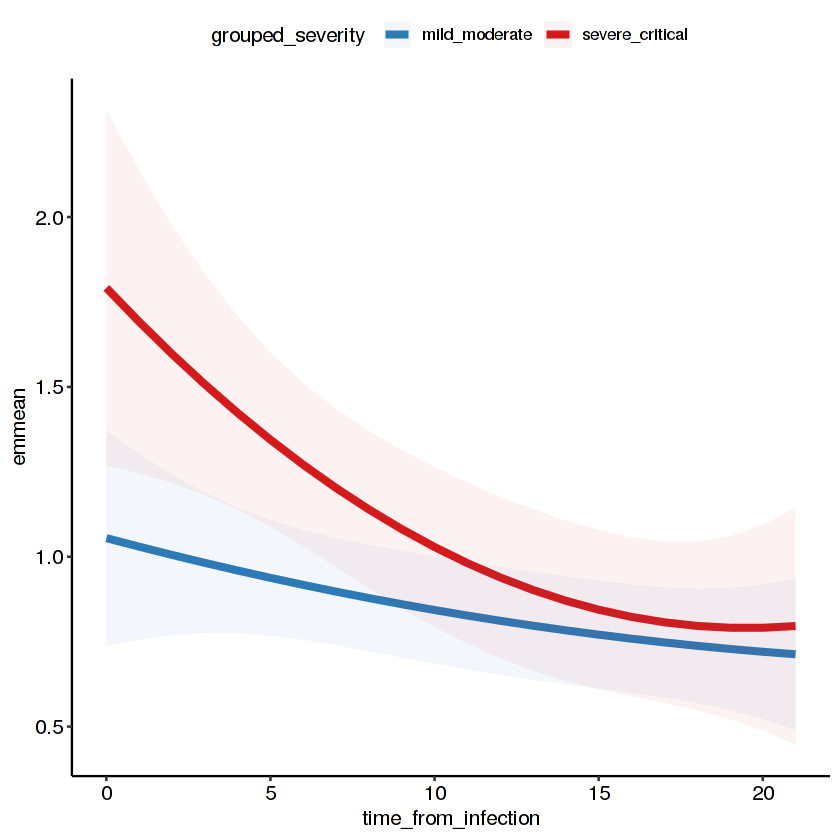

Warning message in grid.Call.graphics(C_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”


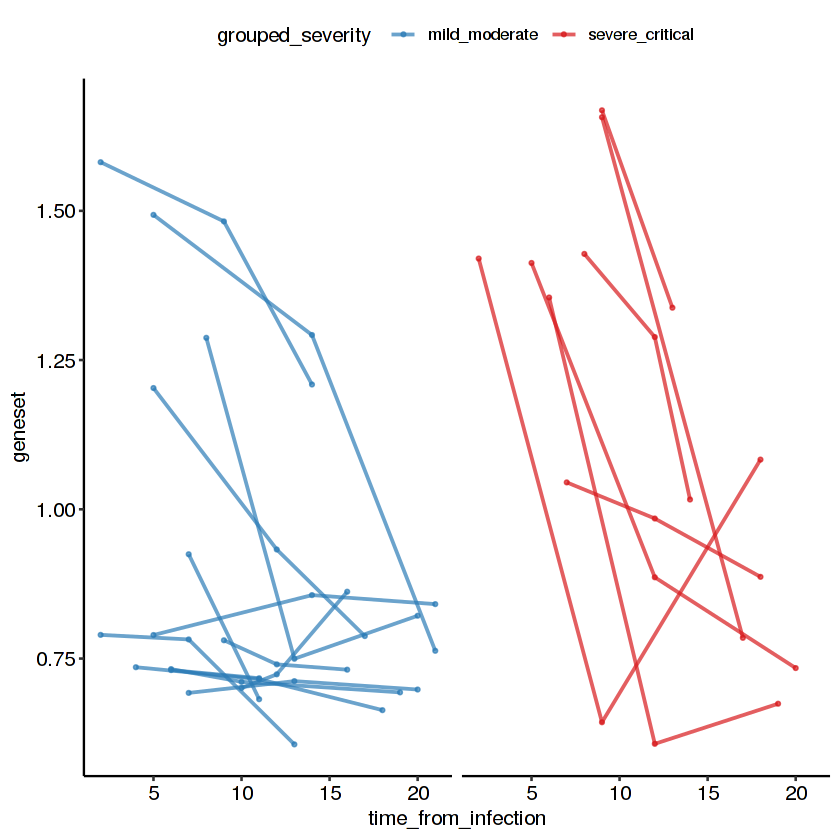

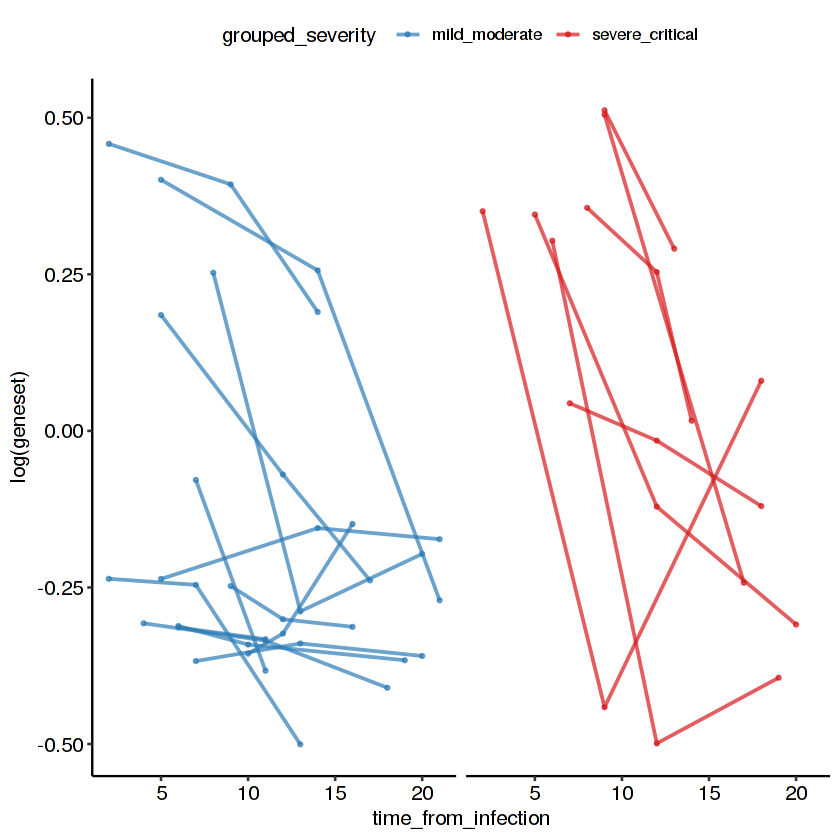

In [21]:
i = 27
x = emmeans(fits1[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

ggplot(fits1[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits1[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

Warning message in splines::bs(time_from_infection, degree = 2L, knots = numeric(0), :
“some 'x' values beyond boundary knots may cause ill-conditioned bases”
Warning message in grid.Call.graphics(C_polygon, x$x, x$y, index):
“semi-transparency is not supported on this device: reported only once per page”
Warning message in grid.Call.graphics(C_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”


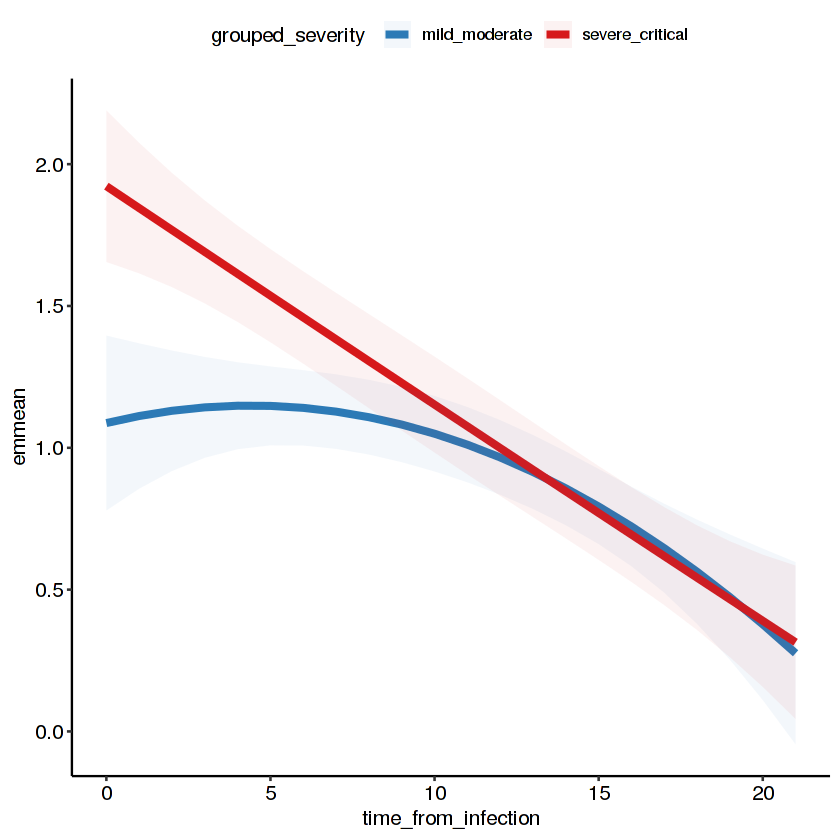

Warning message in grid.Call.graphics(C_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”


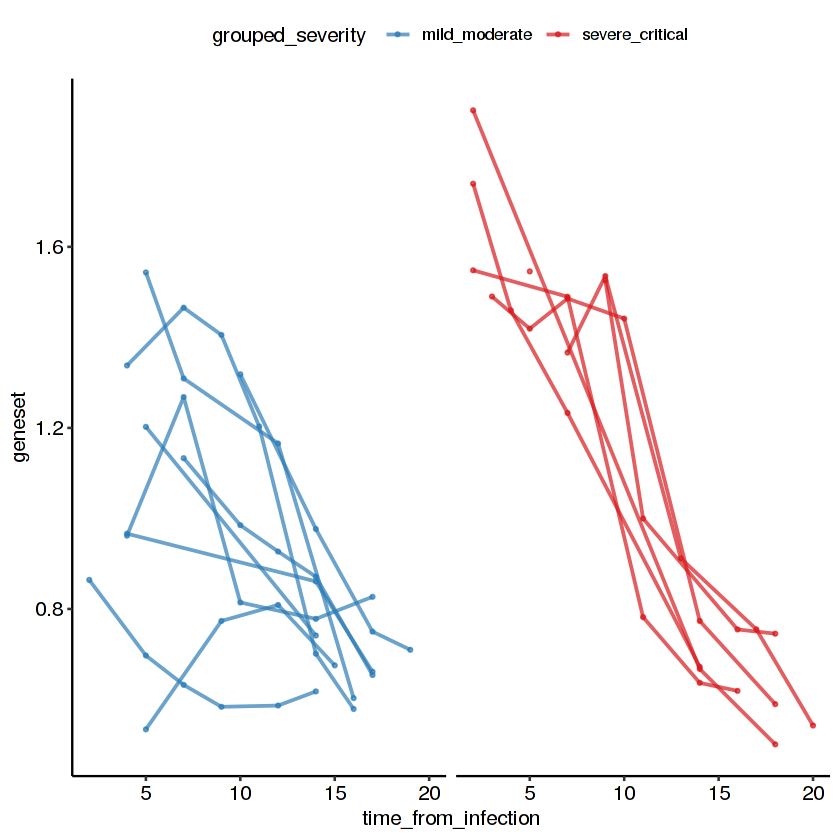

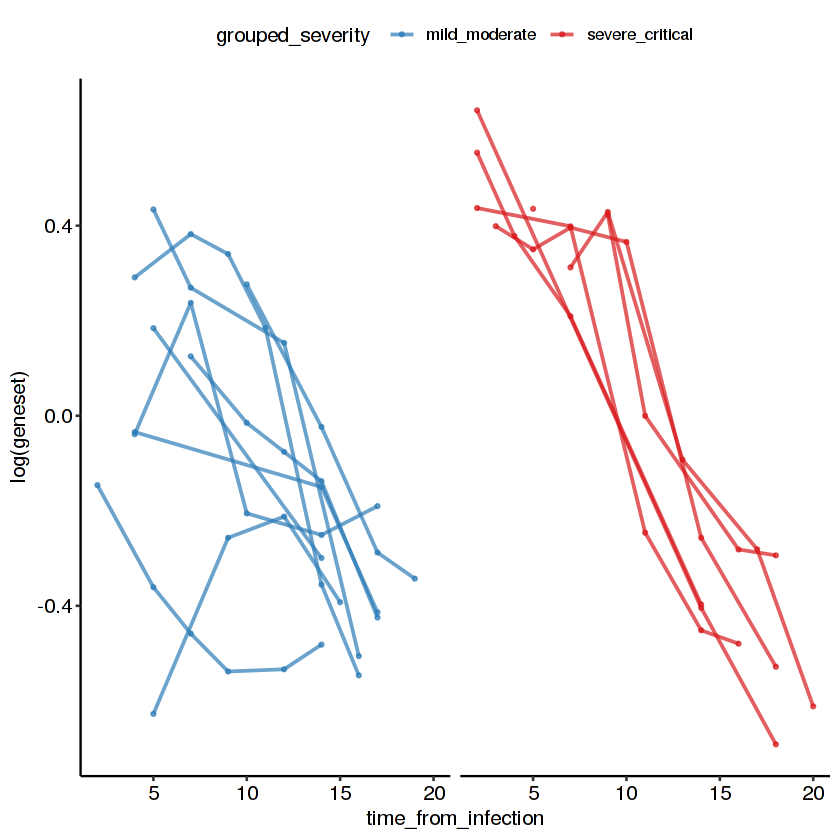

In [22]:
i = 27
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

ggplot(fits2[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

### KEGG

In [23]:
m <- msigdbr(category = 'C2', subcategory = 'CP:KEGG')
genelists <- split(m, m$gs_name)
genelists <- lapply(genelists, function(x) x %>% select(gene_symbol) %>% unlist %>% as.character)

In [24]:
seu1 <- as.Seurat(wave1)
data1 <- seu1@meta.data
seu1 <- AddModuleScore(seu1, features = genelists, name = names(genelists))

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_harmony_rna_ to Xharmonyrna_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xharmonyrna_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_pca_rna_ to Xpcarna_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xpcarna_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_umapafterharmony_rna_ to Xumapafterharmonyrna_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xumapafterharmonyrna_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_umapbeforeharmony_rna_ to Xumapbefor

Warning message:
“The following features are not present in the object: TAS2R45, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: SKP1P2, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: WARS1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: HLA-DRB3, HLA-DRB4, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: SKP1P2, UBE2NL, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: IARS1, LARS1, VARS1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: MMUT, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: IRAG1, not searching for symbol synonyms”
Warning message:
“The following features are not p

In [25]:
seu2 <- as.Seurat(wave2)
data2 <- seu2@meta.data
seu2 <- AddModuleScore(seu2, features = genelists, name = names(genelists))

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_harmony_rna_ to Xharmonyrna_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xharmonyrna_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_pca_rna_ to Xpcarna_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xpcarna_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_umapafterharmony_rna_ to Xumapafterharmonyrna_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to Xumapafterharmonyrna_”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from X_umapbeforeharmony_rna_ to Xumapbefor

Warning message:
“The following features are not present in the object: TAS2R45, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: SKP1P2, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: WARS1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: HLA-DRB3, HLA-DRB4, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: SKP1P2, UBE2NL, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: IARS1, LARS1, VARS1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: MMUT, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: IRAG1, not searching for symbol synonyms”
Warning message:
“The following features are not p

In [26]:
fits1 <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data1$geneset <- seu1@meta.data[,x]
    fit <- lmerTest::lmer(fullFormula, data = data1)
    return(list(fit=fit, data=data1))
})

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSi

In [27]:
fits2 <- lapply(paste0(names(genelists), 1:length(genelists)), function(x){
    data2$geneset <- seu2@meta.data[,x]
    fit <- lmerTest::lmer(fullFormula, data = data2)
    return(list(fit=fit, data=data2))
})

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSingular

boundary (singular) fit: see ?isSi

In [28]:
fit_res1 <- lapply(fits1, function(x) anova(x$fit))
singular1 <- lapply(fits1, function(x) as.numeric(isSingular(x$fit)))
conv1 <- lapply(fits1, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals1 <- lapply(fit_res1, function(x) x[6,6])
qvals1 <- p.adjust(pvals1, method = 'BH')
df1 = data.frame(pvals = unlist(pvals1), 
                qvals = unlist(qvals1), 
                singular = unlist(singular1), 
                conv = unlist(conv1), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df1 = df1[df1$qval < 0.05 & df1$singular == 0 & df1$conv == 0,]
df1

pvals,qvals,singular,conv
<dbl>,<dbl>,<dbl>,<int>


In [29]:
fit_res2 <- lapply(fits2, function(x) anova(x$fit))
singular2 <- lapply(fits2, function(x) as.numeric(isSingular(x$fit)))
conv2 <- lapply(fits2, function(x) length(slot(x$fit, "optinfo")$conv$lme4$messages))
pvals2 <- lapply(fit_res2, function(x) x[6,6])
qvals2 <- p.adjust(pvals2, method = 'BH')
df2 = data.frame(pvals = unlist(pvals2), 
                qvals = unlist(qvals2), 
                singular = unlist(singular2), 
                conv = unlist(conv2), 
                row.names = paste0(names(genelists), 1:length(genelists)))
df2 = df2[df2$qval < 0.05 & df2$singular == 0 & df2$conv == 0,]
df2

,pvals,qvals,singular,conv
,<dbl>,<dbl>,<dbl>,<int>
KEGG_ALLOGRAFT_REJECTION7,1.231192e-03,0.045800326,0,0
KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION13,2.241939e-05,0.004170007,0,0
KEGG_AUTOIMMUNE_THYROID_DISEASE20,9.284116e-04,0.045800326,0,0
KEGG_GRAFT_VERSUS_HOST_DISEASE78,8.899525e-04,0.045800326,0,0
KEGG_TYPE_I_DIABETES_MELLITUS175,1.070069e-03,0.045800326,0,0


Warning message in splines::bs(time_from_infection, degree = 2L, knots = numeric(0), :
“some 'x' values beyond boundary knots may cause ill-conditioned bases”
Warning message in grid.Call.graphics(C_polygon, x$x, x$y, index):
“semi-transparency is not supported on this device: reported only once per page”
Warning message in grid.Call.graphics(C_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”


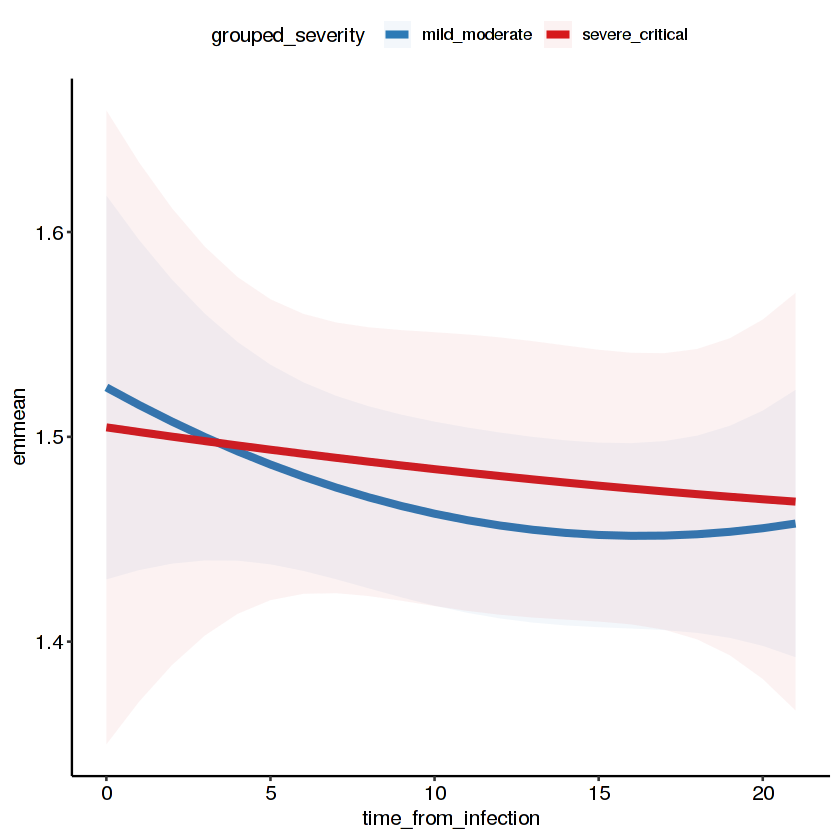

Warning message in grid.Call.graphics(C_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”


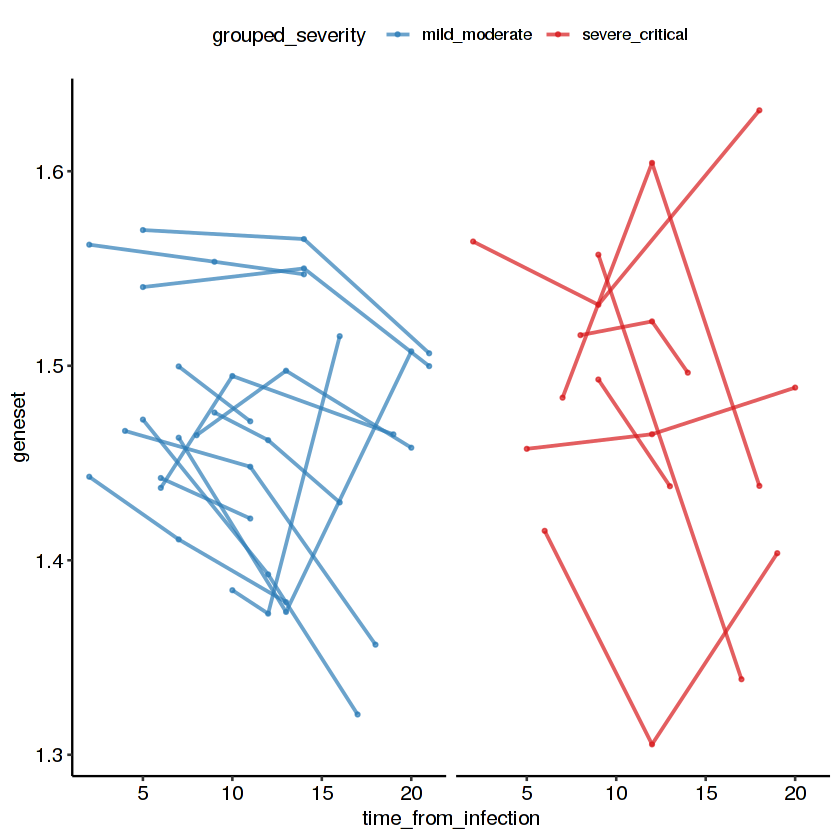

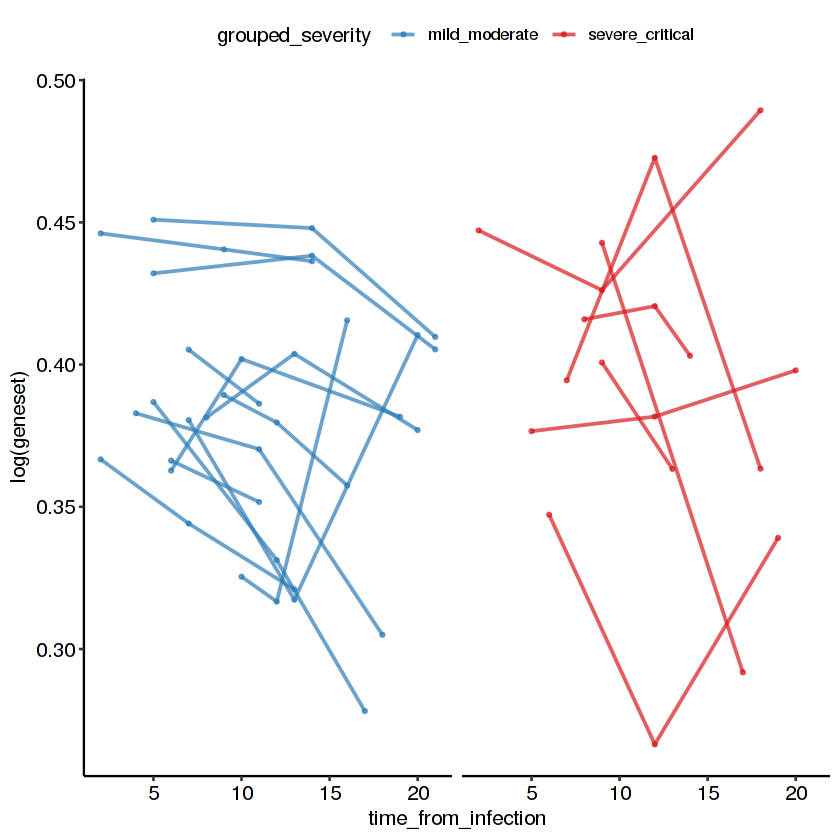

In [31]:
i = 13
x = emmeans(fits1[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

ggplot(fits1[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits1[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

Warning message in splines::bs(time_from_infection, degree = 2L, knots = numeric(0), :
“some 'x' values beyond boundary knots may cause ill-conditioned bases”
Warning message in grid.Call.graphics(C_polygon, x$x, x$y, index):
“semi-transparency is not supported on this device: reported only once per page”
Warning message in grid.Call.graphics(C_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”


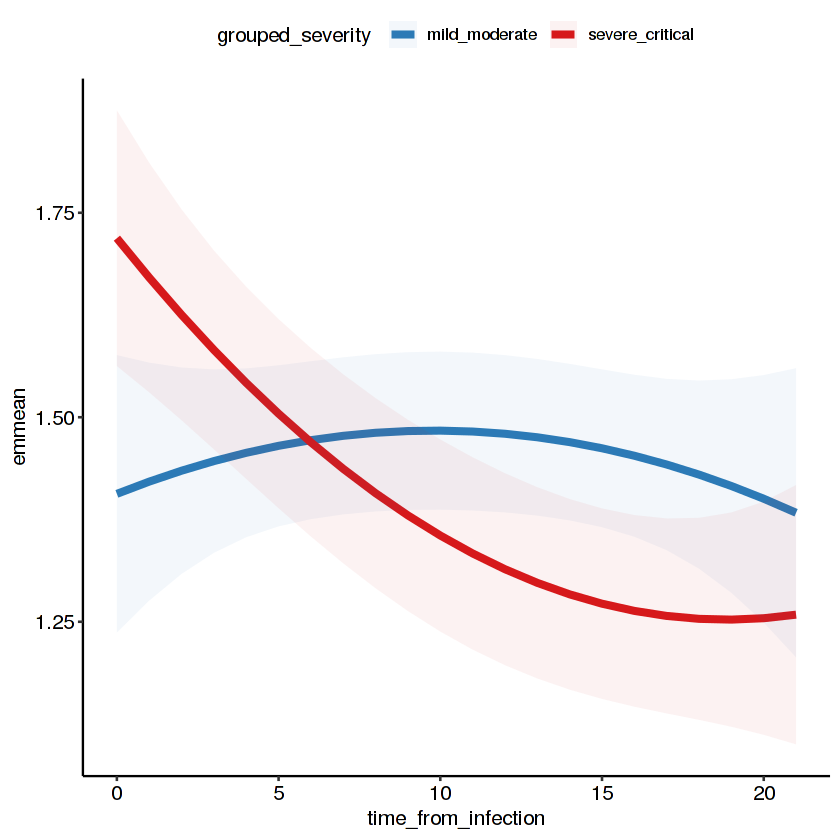

Warning message in grid.Call.graphics(C_points, x$x, x$y, x$pch, x$size):
“semi-transparency is not supported on this device: reported only once per page”


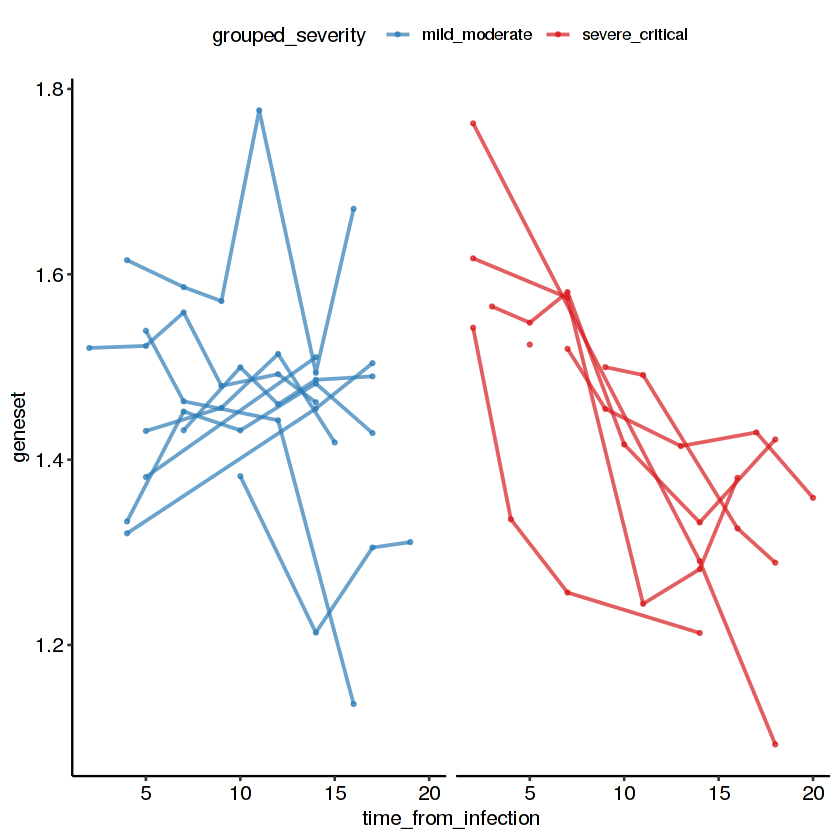

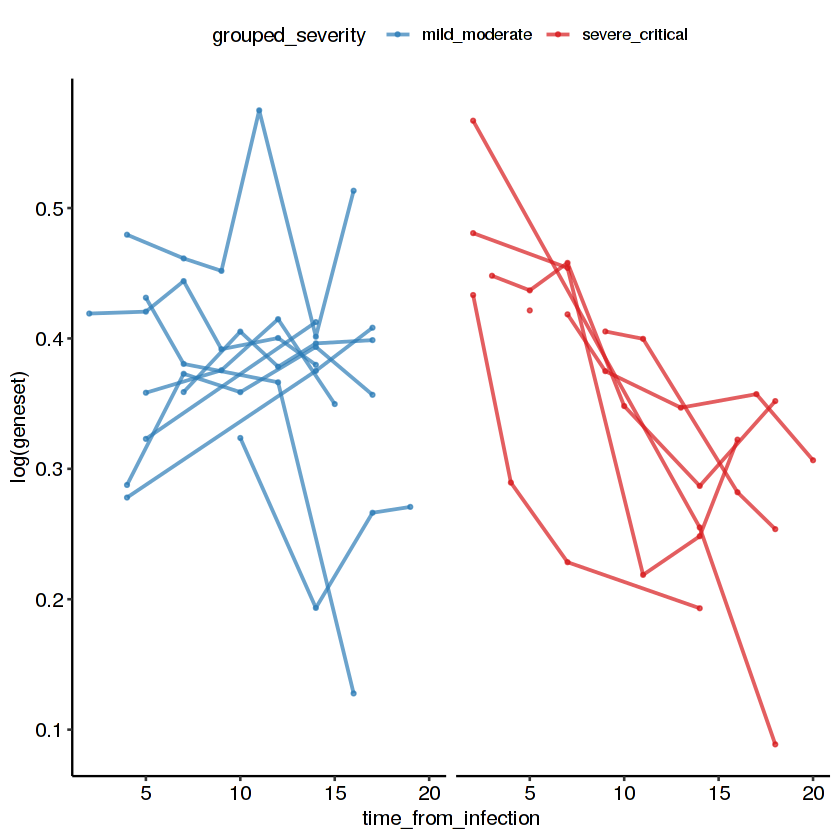

In [32]:
i = 13
x = emmeans(fits2[[i]]$fit, ~ time_from_infection | grouped_severity, at = list(time_from_infection = 0:21))
theme_set(theme_pubr())

ggplot(data.frame(x), aes(time_from_infection, emmean, group = grouped_severity, fill = grouped_severity)) +
    geom_line(aes(colour = grouped_severity), size = 1.7) +
    geom_ribbon(aes(ymin = lower.CL, ymax = upper.CL), alpha = 0.055) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    scale_fill_manual(values = c("#2C7BB6", "#D7191C"))

ggplot(fits2[[i]]$data, aes(time_from_infection, geneset, col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())

ggplot(fits2[[i]]$data, aes(time_from_infection, log(geneset), col = grouped_severity)) +
    geom_point(alpha = 0.7, size = 0.7) +
    geom_line(aes(group = individual_id), alpha = 0.7, size = 0.8) +
    scale_color_manual(values = c("#2C7BB6", "#D7191C")) +
    facet_wrap(~grouped_severity) +
    theme(strip.background = element_blank(), strip.text.x = element_blank(), strip.text.y = element_blank())